#优化岭回归参数

当你使用岭回归模型进行建模时，需要考虑`Ridge`的`alpha`参数。

例如，用OLS（普通最小二乘法）做回归也许可以显示两个变量之间的某些关系；但是，当`alpha`参数正则化之后，那些关系就会消失。做决策时，这些关系是否需要考虑就显得很重要了。

<!-- TEASER_END -->

##Getting ready

这是我们第一个进行模型参数优化的主题，通常用交叉检验（cross validation）完成。在后面的主题中，还会有更简便的方式实现这些，但是这里我们一步一步来实现岭回归的优化。

在scikit-learn里面，岭回归的$\Gamma$参数就是`RidgeRegression`的`alpha`参数；因此，问题就是最优的`alpha`参数是什么。首先我们建立回归数据集：

In [1]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=100, n_features=2, effective_rank=1, noise=10)

##How to do it...

在`linear_models`模块中，有一个对象叫`RidgeCV`，表示**岭回归交叉检验（ridge cross-validation）**。这个交叉检验类似于**留一交叉验证法（leave-one-out cross-validation，LOOCV）**。这种方法是指训练数据时留一个样本，测试的时候用这个未被训练过的样本：

In [2]:
import numpy as np
from sklearn.linear_model import RidgeCV
rcv = RidgeCV(alphas=np.array([.1, .2, .3, .4]))
rcv.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

拟合模型之后，`alpha`参数就是最优参数：

In [3]:
rcv.alpha_

0.10000000000000001

这里，`0.1`是最优参数，我们还想看到`0.1`附近更精确的值：

In [4]:
rcv = RidgeCV(alphas=np.array([.08, .09, .1, .11, .12]))
rcv.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.08,  0.09,  0.1 ,  0.11,  0.12]), cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [5]:
rcv.alpha_

0.080000000000000002

可以按照这个思路一直优化下去，这里只做演示，后面还是介绍更好的方法。

##How it works...

上面的演示很直接，但是我们介绍一下为什么这么做，以及哪个值才是最优的。在交叉检验的每一步里，模型的拟合效果都是用测试样本的误差表示。默认情况使用平方误差。更多细节见`There's more...`一节。

我们可以让`RidgeCV`储存交叉检验的数据，这样就可以可视化整个过程：

In [6]:
alphas_to_test = np.linspace(0.0001, 0.05)
rcv3 = RidgeCV(alphas=alphas_to_test, store_cv_values=True)
rcv3.fit(reg_data, reg_target)

RidgeCV(alphas=array([ 0.0001 ,  0.00112,  0.00214,  0.00316,  0.00417,  0.00519,
        0.00621,  0.00723,  0.00825,  0.00927,  0.01028,  0.0113 ,
        0.01232,  0.01334,  0.01436,  0.01538,  0.01639,  0.01741,
        0.01843,  0.01945,  0.02047,  0.02149,  0.0225 ,  0.02352,
        0.02454,  0.02556...4185,
        0.04287,  0.04389,  0.04491,  0.04593,  0.04694,  0.04796,
        0.04898,  0.05   ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

你会看到，我们测试了0.0001到0.05区间中的50个点。由于我们把`store_cv_values`设置成`true`，我们可以看到每一个值对应的拟合效果：

In [7]:
rcv3.cv_values_.shape

(100, 50)

通过100个样本的回归数据集，我们获得了50个不同的`alpha`值。我们可以看到50个误差值，最小的均值误差对应最优的`alpha`值：

In [8]:
smallest_idx = rcv3.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx]

0.014357142857142857

此时问题转化成了“RidgeCV认可我们的选择吗？”可以再用下面的命令获取`alpha`值：

In [9]:
rcv3.alpha_

0.014357142857142857

通过可视化图形可以更直观的显示出来。我们画出50个测试`alpha`值的图：

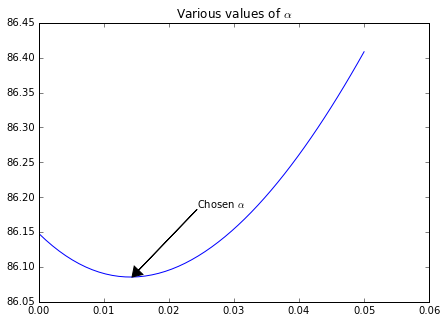

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title(r"Various values of $\alpha$")

xy = (alphas_to_test[smallest_idx], rcv3.cv_values_.mean(axis=0)[smallest_idx])
xytext = (xy[0] + .01, xy[1] + .1)

ax.annotate(r'Chosen $\alpha$', xy=xy, xytext=xytext,
            arrowprops=dict(facecolor='black', shrink=0, width=0)
            )
ax.plot(alphas_to_test, rcv3.cv_values_.mean(axis=0));

##There's more...

如果我们想用其他误差自定义评分函数，也是可以实现的。前面我们介绍过MAD误差，我们可以用它来评分。首先我们需要定义损失函数：

In [11]:
def MAD(target, prediction):
    absolute_deviation = np.abs(target - prediction)
    return absolute_deviation.mean()

定义损失函数之后，我们用`sklearn`量度中的`make_scorer`函数来处理。这样做可以标准化自定义的函数，让scikit-learn对象可以使用它。另外，由于这是一个损失函数不是一个评分函数，是越低越好，所以要用`sklearn`来把最小化问题转化成最大化问题：

In [12]:
import sklearn
MAD = sklearn.metrics.make_scorer(MAD, greater_is_better=False)
rcv4 = RidgeCV(alphas=alphas_to_test, store_cv_values=True, scoring=MAD)
rcv4.fit(reg_data, reg_target)
smallest_idx = rcv4.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx]

0.050000000000000003